## Import Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import os
import numpy as np
import matplotlib.pyplot as plt

losses = []

## Check For GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## EgdePtychoNN Model

In [3]:
class ReconSmallPhaseModel(nn.Module):
    def __init__(self, nconv: int = 16):
        super(ReconSmallPhaseModel, self).__init__()
        self.nconv = nconv
        self.encoder = nn.Sequential( # Appears sequential has similar functionality as TF avoiding need for separate model definition and activ
            *self.down_block(1, self.nconv),
            *self.down_block(self.nconv, self.nconv * 2),
            *self.down_block(self.nconv * 2, self.nconv * 4),
            *self.down_block(self.nconv * 4, self.nconv * 8), 
            *self.down_block(self.nconv * 8, self.nconv * 16), 
            *self.down_block(self.nconv * 16, self.nconv * 32),
            #*self.down_block(self.nconv * 32, self.nconv * 32)   # Commented out to make outputs match labels (128,128) instead of (64,64)
        )
        
        # amplitude model
        #self.decoder1 = nn.Sequential(
            #*self.up_block(self.nconv * 32, self.nconv * 32),
         #   *self.up_block(self.nconv * 32, self.nconv * 16),
          #  *self.up_block(self.nconv * 16, self.nconv * 8),
           # *self.up_block(self.nconv * 8, self.nconv * 8),
            #*self.up_block(self.nconv * 8, self.nconv * 4),
            #*self.up_block(self.nconv * 4, self.nconv * 2),
            #*self.up_block(self.nconv * 2, self.nconv * 1),
            #nn.Conv2d(self.nconv * 1, 1, 3, stride=1, padding=(1,1)),
        #)
        
        # phase model
        self.decoder2 = nn.Sequential(
            #*self.up_block(self.nconv * 32, self.nconv * 32),
            *self.up_block(self.nconv * 32, self.nconv * 16),
            *self.up_block(self.nconv * 16, self.nconv * 8),
            *self.up_block(self.nconv * 8, self.nconv * 8),
            *self.up_block(self.nconv * 8, self.nconv * 4),
            *self.up_block(self.nconv * 4, self.nconv * 2),
            *self.up_block(self.nconv * 2, self.nconv * 1),
            nn.Conv2d(self.nconv * 1, 1, 3, stride=1, padding=(1,1)),
            nn.Tanh()
        )
    def down_block(self, filters_in, filters_out):
        block = [
            nn.Conv2d(in_channels=filters_in, out_channels=filters_out, kernel_size=3, stride=1, padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(filters_out, filters_out, 3, stride=1, padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d((2,2))
        ]
        return block
    
    
    def up_block(self, filters_in, filters_out):
        block = [
            nn.Conv2d(filters_in, filters_out, 3, stride=1, padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(filters_out, filters_out, 3, stride=1, padding=(1,1)),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear')
        ]
        return block
        
    
    def forward(self, x):
        with torch.cuda.amp.autocast():
            #print("Input size:", x.size())  # Print input size
            x1 = self.encoder(x)
            #print("After encoder:", x1.size())  # Print size after encoder
            
            # amp = self.decoder1(x1)  # If you want to test decoder1 as well
            ph = self.decoder2(x1)
            #print("After decoder2:", ph.size())  # Print size after decoder2
            
            # Restore -pi to pi range
            ph = ph * np.pi  # Using tanh activation (-1 to 1) for phase, so multiply by pi
            #print("Final output size:", ph.size())  # Print final output size

        return ph

## Get Data From Scan Files

In [4]:
class PtychographyDataset(Dataset):
    def __init__(self, npz_files):

        # Initialize empty lists for inputs and labels from all files
        all_inputs = []
        all_labels = []

        # Loop through all 10 files
        for npz_file in npz_files:
            data = np.load(npz_file)
            inputs = torch.tensor(data["reciprocal"], dtype=torch.float32)
            labels = np.angle(data["real"])
            labels = torch.tensor(labels, dtype=torch.float32)

            # Ensure input and label shapes are correct 
            if len(inputs.shape) == 3:  
                inputs = inputs.unsqueeze(1)  # Add channel dim (C=1)
                labels = labels.unsqueeze(1)  # Add channel dim (C=1)

            # Append the data from file to lists
            all_inputs.append(inputs)
            all_labels.append(labels)

        # Concatenate all data 
        self.inputs = torch.cat(all_inputs, dim = 0)
        self.labels = torch.cat(all_labels, dim = 0)


    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

## Initialize The Model

In [5]:
# List of file paths
npz_files = [
    "/home/sfowler/Downloads/NewScans/scan674.npz", "/home/sfowler/Downloads/NewScans/scan683.npz", "/home/sfowler/Downloads/NewScans/scan692.npz", 
    "/home/sfowler/Downloads/NewScans/scan701.npz", "/home/sfowler/Downloads/NewScans/scan710.npz", "/home/sfowler/Downloads/NewScans/scan720.npz", 
    "/home/sfowler/Downloads/NewScans/scan730.npz", "/home/sfowler/Downloads/NewScans/scan740.npz", "/home/sfowler/Downloads/NewScans/scan750.npz", 
    "/home/sfowler/Downloads/NewScans/scan760.npz", "/home/sfowler/Downloads/NewScans/scan770.npz"
]

# Load dataset
train_dataset = PtychographyDataset(npz_files)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model
model = ReconSmallPhaseModel()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5) # First Optimizer I tried
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9) # Caused Convergance 
#optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1)
#scalar = torch.GradScaler()
#criterion = nn.MSELoss()  #First Loss I tried
criterion = nn.L1Loss() # Second Loss I tried
#criterion = nn.SmoothL1Loss() # Changed Loss 

## Training Function

In [6]:
def train(model, train_loader, criterion, optimizer, start_epoch, num_epochs, device):
#def train(model, train_loader, criterion, optimizer, scheduler, start_epoch, num_epochs, device):
    model.train()  # Set model to training mode
    for epoch in range(start_epoch, start_epoch + num_epochs):
        running_loss = 0.0  # Track total loss for the epoch
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU if available

            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs)  # Forward pass

            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters

            losses.append(loss.item())
            running_loss += loss.item()  # Accumulate loss

        #scheduler.step()
        avg_loss = running_loss / len(train_loader)  # Compute average loss per batch
        print(f"Epoch [{epoch+1}/{start_epoch + num_epochs}], Ave Loss: {avg_loss:.5f}, Loss: {loss.item():.5f}, Learning Rate: {optimizer.param_groups[0]['lr']}")

        final_loss = loss # Update final loss to the current epochs average loss

    print("Training complete.")
    return final_loss

## Save Model State

In [7]:
def save_state(model, optimizer, epoch, loss, filename="checkpoint.pth"):
#def save_state(model, optimizer, scheduler, epoch, loss, filename="checkpoint.pth"):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        #'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss
    }
    torch.save(state, filename)
    print(f"Checkpoint saved at epoch {epoch}")

## Load Model State

In [8]:
def load_state(model, optimizer, filename="checkpoint.pth"):
#def load_state(model, optimizer, scheduler, filename="checkpoint.pth"):
    state = torch.load(filename)
    
    model.load_state_dict(state['model_state_dict'])
    optimizer.load_state_dict(state['optimizer_state_dict'])
    #scheduler.load_state_dict(state['scheduler_state_dict'])
    
    start_epoch = state['epoch'] + 1  # Resume from the next epoch
    loss = state['loss']
    
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")
    #return model, optimizer, scheduler, start_epoch, loss
    return model, optimizer, start_epoch, loss


## Train Model

In [12]:
checkpoint_path = "checkpoint.pth"

# If there's a checkpoint, load it.
if os.path.exists(checkpoint_path):
    model, optimizer, start_epoch, last_loss = load_state(model, optimizer, checkpoint_path)
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 0
    print(f"Starting fresh training from epoch {start_epoch}")

# Define the total number of epochs you want to train in this run.
num_epochs = 1

final_loss = train(model, train_loader, criterion, optimizer, start_epoch, num_epochs, device)

final_epoch = start_epoch + num_epochs - 1  # last epoch trained in this run

save_state(model, optimizer, final_epoch, final_loss, filename=checkpoint_path)

losses_np = np.array(losses)
print(f"Loss statistics over all batches:")
print(f"Min:  {losses_np.min():.4f}")
print(f"Max:  {losses_np.max():.4f}")
print(f"Mean: {losses_np.mean():.4f}")
print(f"Std:  {losses_np.std():.4f}")

Checkpoint loaded. Resuming from epoch 340
Resuming training from epoch 340
Epoch [341/341], Ave Loss: 0.12904, Loss: 0.17693, Learning Rate: 3e-05
Training complete.
Checkpoint saved at epoch 340
Loss statistics over all batches:
Min:  0.1162
Max:  0.1769
Mean: 0.1292
Std:  0.0056


In [13]:
for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    print("Outputs Min:", outputs.min().item(), "Max:", outputs.max().item(), "Mean:", outputs.mean().item())
    break

Outputs Min: -2.204472780227661 Max: 1.1617085933685303 Mean: 0.03900217264890671


## Visualize Output

Output Stats - Min: -2.2213869094848633 Max: 1.2713755369186401 Mean: 0.0695759654045105


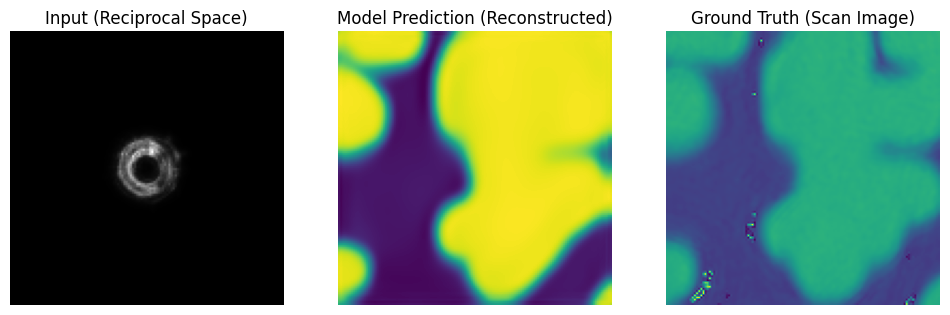

Output Stats - Min: -2.2213869094848633 Max: 1.2713755369186401 Mean: 0.0695759654045105


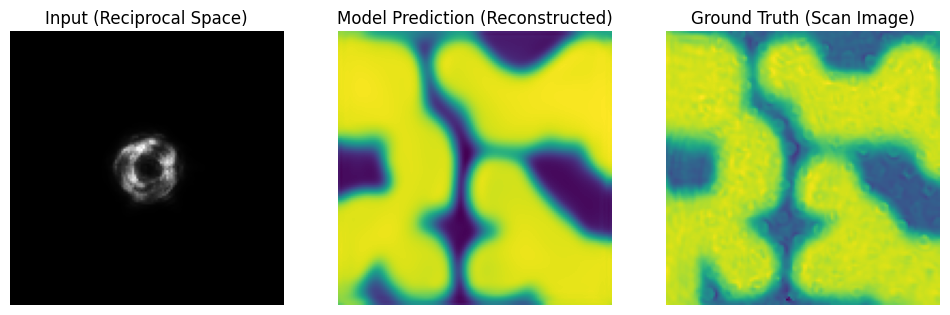

Output Stats - Min: -2.2213869094848633 Max: 1.2713755369186401 Mean: 0.0695759654045105


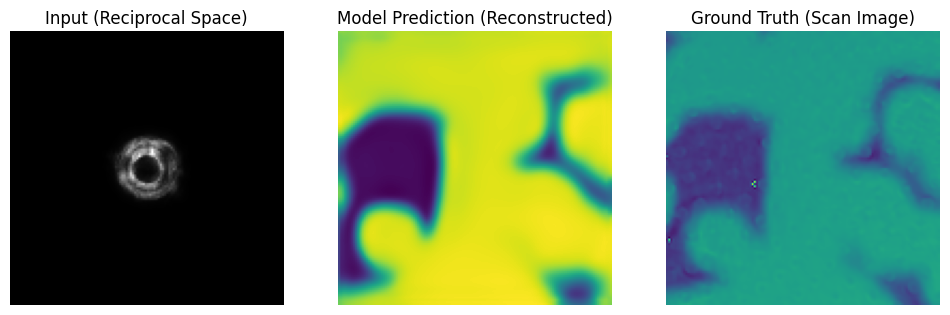

In [29]:
def normalize_image(image):
    min_val, max_val = image.min(), image.max()
    return (image - min_val) / (max_val - min_val) if max_val > min_val else image

def visualize_prediction(model, dataloader, num_samples=1):
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in dataloader:  # Get a batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Model's predicted image
            break  # Only take the first batch

    for i in range(num_samples):  # Loop through first few samples
        print("Output Stats - Min:", outputs.min().item(), "Max:", outputs.max().item(), "Mean:", outputs.mean().item())

        plt.figure(figsize=(12, 4))

        # Original scan (Ground Truth)
        plt.subplot(1, 3, 1)
        plt.imshow(inputs[i, 0].cpu().numpy(), cmap="gray")
        plt.title("Input (Reciprocal Space)")
        plt.axis("off")

        # Model Prediction
        plt.subplot(1, 3, 2)
        plt.imshow(outputs[i, 0].cpu().numpy(), cmap="viridis")
        plt.title("Model Prediction (Reconstructed)")
        plt.axis("off")

        # Ground Truth
        plt.subplot(1, 3, 3)
        plt.imshow(labels[i, 0].cpu().numpy(), cmap="viridis")
        plt.title("Ground Truth (Scan Image)")
        plt.axis("off")

        plt.show()

# Run visualization
visualize_prediction(model, train_loader, num_samples=3)

SSIM: 0.7959


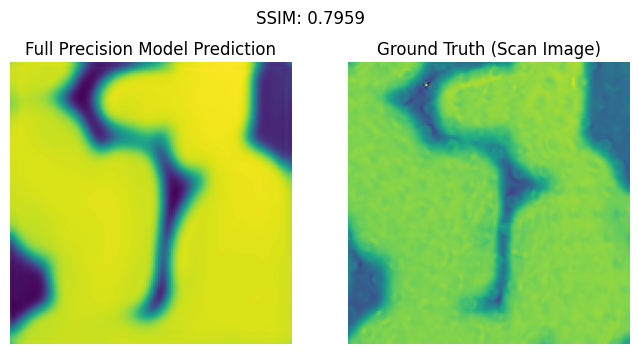

In [37]:
from skimage.metrics import structural_similarity as ssim

def normalize(img):
    return (img - img.min()) / (img.max() - img.min()) if img.max() > img.min() else img

def visualize_single_sample_from_file(model, file_path, device):
    
    # Load the data from the file directly
    data = np.load(file_path)
    input_image = torch.tensor(data["reciprocal"], dtype=torch.float32)
    label_image = np.angle(data["real"])
    label_image = torch.tensor(label_image, dtype=torch.float32)

    # Take a specific sample
    input_image = input_image[200].unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, H, W]
    label_image = label_image[200].unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]

    # Run model
    model.eval()
    with torch.no_grad():
        output_image = model(input_image)

    # Convert to numpy for comparison
    output_np = output_image[0, 0].cpu().numpy()
    label_np = label_image[0, 0].cpu().numpy()

    # Normalize before SSIM
    output_norm = normalize(output_np)
    label_norm = normalize(label_np)

    # Compute SSIM
    ssim_score = ssim(output_norm, label_norm, data_range=1.0)
    print(f"SSIM: {ssim_score:.4f}")


    # Plot prediction and ground truth
    plt.figure(figsize=(8, 4))

    # Model Prediction
    plt.subplot(1, 2, 1)
    plt.imshow(output_image[0, 0].cpu().numpy(), cmap="viridis")
    plt.title("Full Precision Model Prediction")
    plt.axis("off")

    # Ground Truth
    plt.subplot(1, 2, 2)
    plt.imshow(label_image[0, 0].cpu().numpy(), cmap="viridis")
    plt.title("Ground Truth (Scan Image)")
    plt.axis("off")

    plt.suptitle(f"SSIM: {ssim_score:.4f}", fontsize=12)
    plt.show()


visualize_single_sample_from_file(model, "/home/sfowler/Downloads/NewScans/scan674.npz", device)
